# output space exploration

Output space exploration is a form of optimization based on novelty search. In the workbench, it relies on the optimization functionality. You can use output space exploration by passing an instance of either `OutputSpaceExploration` or `AutoAdaptiveOutputSpaceExploration` as algorithm to `evaluator.optimize`. The fact that output space exploration uses the optimization functionality also implies that we can track convergence in a similar manner. Epsilon progress is defined identical, but evidently other metrics such as hypervolume might not be applicable in the context of output space exploration.

The difference between `OutputSpaceExploration` and `AutoAdaptiveOutputSpaceExploration` is in the evolutionary operators. `AutoAdaptiveOutputSpaceExploration` uses auto adaptive operator selection as implemented in the BORG MOEA, while `OutputSpaceExploration` by default uses Simulated Binary crossover with polynomial mutation. Injection of new solutions is handled through auto adaptive population sizing and periodically starting with a new population if search is stalling. Below, examples are given of how to use both algorithms, as well as a a quick visualization of the convergence dynamics.

For this example, we are using a stylized case study frequently used to develop and test decision making under deep uncertainty methods: the shallow lake problem. In this problem, a city has to decide on the ammount of polution they are going to put into a shallow lake per year. The city gets benefits from poluting the lake, but if an unknown threshold is crossed, the lake permenantly shifts to an undesirable poluted state. For further details on this case study, see for example [Quinn et al, 2017](https://doi.org/10.1016/j.envsoft.2017.02.017) and [Bartholomew et al, 2021](https://doi.org/10.1016/j.envsoft.2020.104699).


In [1]:
from lake_model_outputspace_exploration import lake_problem

from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    Policy,
    SequentialEvaluator,
    OutputSpaceExploration
)

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)
lake_model.time_horizon = 100

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers, one for each time step
lake_model.levers = [
    RealParameter(str(i), 0, 0.1) for i in range(lake_model.time_horizon)
]

# specify outcomes
# output space exploration

lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
lake_model.constants = [Constant("alpha", 0.41), Constant("nsamples", 150)]



Above, we have setup the lake problem, specified the uncertainties, policy levers, outcomes of interest and (optionally) some constants. We are now ready to run output space exploration on this model. For this, we use the default optimization functionality of the world bank, but pass the `OutputSpaceExploration` class. Below, we are running output space exploration over the uncertainties, which implies we need to pass a reference policy. We also rerun the algorithm for 5 different seeds. We can track convergence of the outputspace epxloration by tracking $\epsilon$-progress.

The `grid_spec` keyword argument, which is specific to output space exploration specifies the grid structure we are imposing on the output space. There must be a tuple for each outcome of interest. Each tuple specifies the minimum value, the maximum value and the size of the grid cell on this outcome dimension. 

In [3]:
from ema_workbench.em_framework.optimization import EpsilonProgress

# generate some default policy 
reference = Policy('nopolicy', **{l.name:0.02 for l in lake_model.levers})
n_seeds = 5

convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    for _ in range(n_seeds):
        convergence_metrics = [
            EpsilonProgress(),
        ]        
        res, convergence = evaluator.optimize(algorithm=OutputSpaceExploration,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=25000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 convergence=convergence_metrics)
        convergences.append(convergence)
    

[MainProcess/INFO] pool started with 10 workers
26625it [01:40, 265.19it/s]                                                    
[MainProcess/INFO] optimization completed, found 1375 solutions
28514it [01:47, 265.52it/s]                                                    
[MainProcess/INFO] optimization completed, found 1386 solutions
28336it [01:49, 259.12it/s]                                                    
[MainProcess/INFO] optimization completed, found 1372 solutions
28638it [01:49, 262.33it/s]                                                    
[MainProcess/INFO] optimization completed, found 1383 solutions
28227it [01:48, 259.60it/s]                                                    
[MainProcess/INFO] optimization completed, found 1374 solutions
[MainProcess/INFO] terminating pool


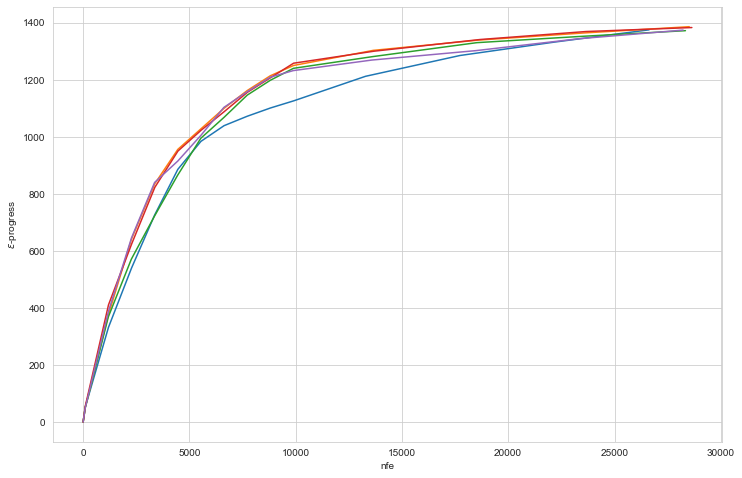

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
    
ax.set_xlabel("nfe")
ax.set_ylabel("$\epsilon$-progress")
plt.show()

The figure above shows the $\epsilon$-progress per nfe for each of the five random seeds. As can be seen, the algorithm converges to essentially the same amount of epsilon progress across the seeds. This suggests that the algorithm has converged and thus found all possible output grid cells. 

## auto adaptive operator selection
The foregoing example used the default version of the output space exploration algorithm. This algorithm uses Simulated Binary Crossover (SBX) with Polynomial Mutation (PM) as its evolutionary operators. However, it is conceivable that for some problems other evolutionary operators might be more suitable. You can pass your own combination of operators if desired using [platypus](https://platypus.readthedocs.io/en/latest/). For general use, however, it can sometimes be easier to let the algorithm itself figure out which operators to use. To support this, we also provide an `AutoAdaptiveOutputSpaceExploration` algorithm. This algorithm uses Auto Adaptive Operator selection as also used in the [BORG algorithm](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.469.9675&rep=rep1&type=pdf). Note that this algorithm is limited to RealParameters only.

In [5]:
from ema_workbench.em_framework.outputspace_exploration import AutoAdaptiveOutputSpaceExploration
from ema_workbench.em_framework.optimization import OperatorProbabilities


convergences = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    
    for _ in range(5):
        convergence_metrics = [
            EpsilonProgress(),
            OperatorProbabilities("SBX", 0),
            OperatorProbabilities("PCX", 1),
            OperatorProbabilities("DE", 2),
            OperatorProbabilities("UNDX", 3),    
            OperatorProbabilities("SPX", 4),    
            OperatorProbabilities("UM", 5),    
        ]    
        res, convergence = evaluator.optimize(algorithm=AutoAdaptiveOutputSpaceExploration,
                                 grid_spec=[(0, 12, 0.5),
                                            (0, 0.6, 0.05),
                                            (0, 1, 0.1),
                                            (0, 1, 0.1)],
                                 nfe=25000,
                                 searchover='uncertainties',
                                 reference=reference,
                                 variator=None,
                                 convergence=convergence_metrics)
        convergences.append(convergence)
    

[MainProcess/INFO] pool started with 10 workers
29556it [01:56, 252.85it/s]                                                    
[MainProcess/INFO] optimization completed, found 1437 solutions
30067it [01:58, 253.31it/s]                                                    
[MainProcess/INFO] optimization completed, found 1443 solutions
29957it [01:55, 259.12it/s]                                                    
[MainProcess/INFO] optimization completed, found 1458 solutions
30091it [01:57, 256.60it/s]                                                    
[MainProcess/INFO] optimization completed, found 1451 solutions
30167it [01:58, 254.13it/s]                                                    
[MainProcess/INFO] optimization completed, found 1443 solutions
[MainProcess/INFO] terminating pool


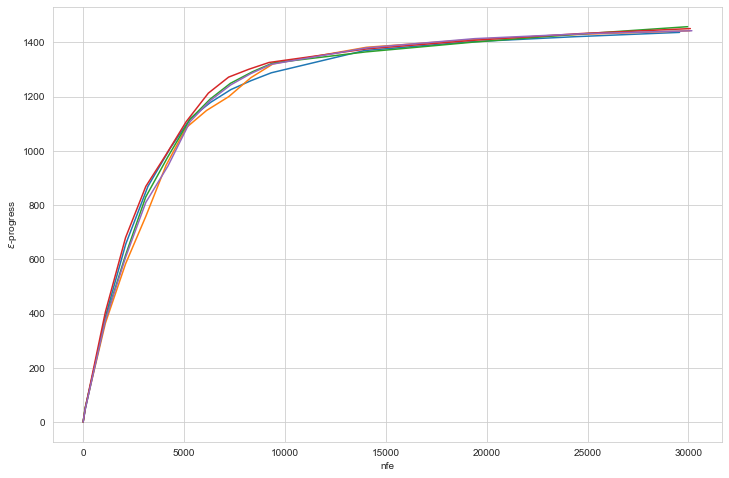

In [7]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
for convergence in convergences:
    ax.plot(convergence.nfe, convergence.epsilon_progress)
    
ax.set_xlabel("nfe")
ax.set_ylabel("$\epsilon$-progress")    
plt.show()

Above, you see the $\epsilon$-convergence for the auto adaptive operator selection version of the outputspace algorithm. Like the normal version, it converges to essential the same number across the different seeds. Note also that the $\epsilon$-progress is slightly higher, and also the total number of identified solutions (see log messages) is higher. That suggests that for even for a relatively simple problem, there is value in using the auto adaptive operator selection. 

In case of `AutoAdaptiveOutputSpaceExploration` it can sometimes also be revealing to check the dynamics of the operators over the evolution. This is shown below separately for each seed. For the meaning of the abbreviations, check the [BORG algorithm](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.469.9675&rep=rep1&type=pdf).

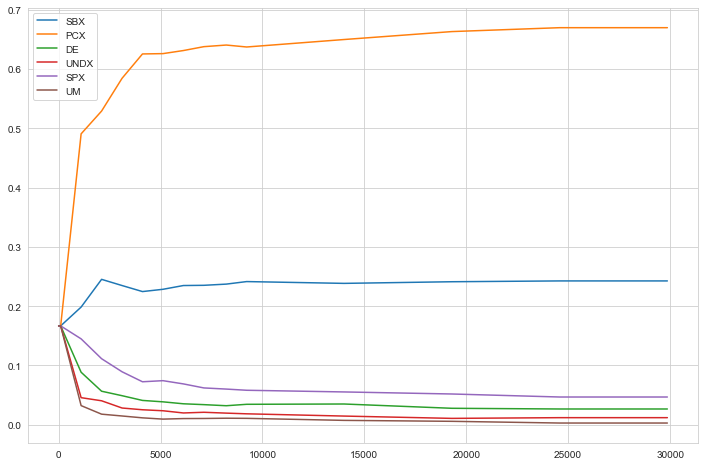

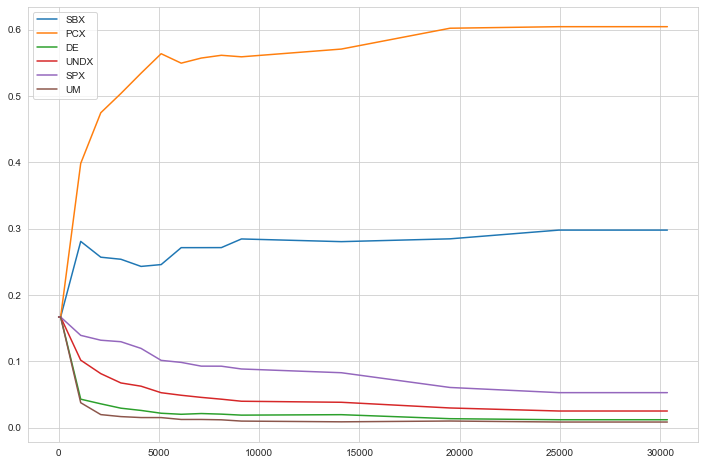

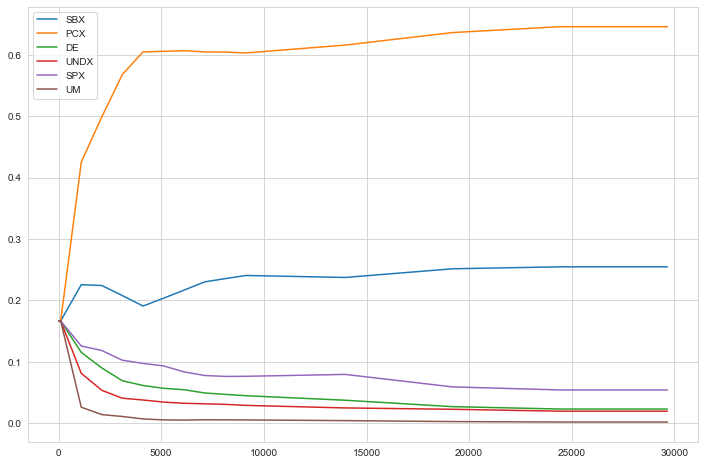

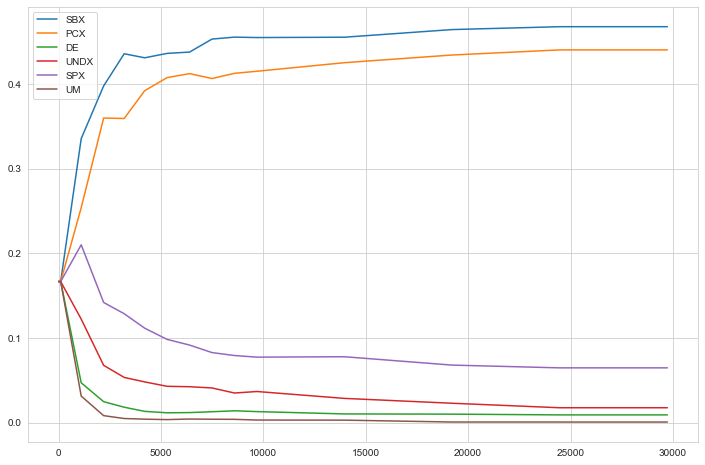

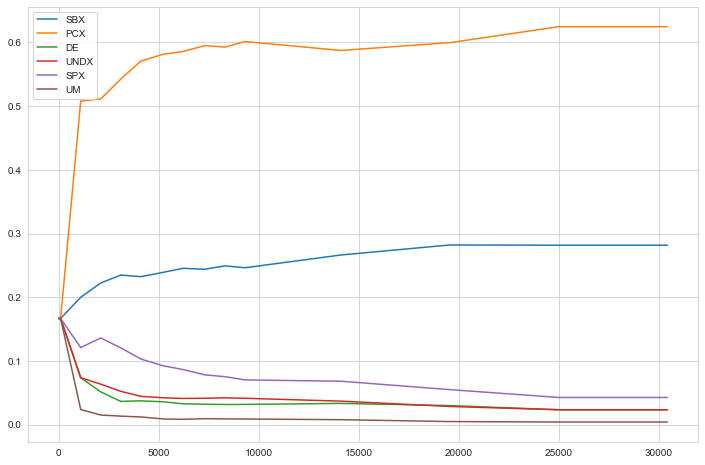

In [8]:
for convergence in convergences:
    fig, ax = plt.subplots()    
    ax.plot(convergence.nfe, convergence.SBX, label='SBX')
    ax.plot(convergence.nfe, convergence.PCX, label='PCX')
    ax.plot(convergence.nfe, convergence.DE, label='DE')
    ax.plot(convergence.nfe, convergence.UNDX, label='UNDX')
    ax.plot(convergence.nfe, convergence.SPX, label='SPX')
    ax.plot(convergence.nfe, convergence.UM, label='UM')
    ax.legend()
plt.show()

# LHS

for comparison, let's also generate a Latin Hypercube Sample and compare the results. Since the output space exploration return close to 1500 solutions, we use 1500 for LHS as well. 

In [8]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(
                             scenarios=1500,
                             policies=reference)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1500 scenarios * 1 policies * 1 model(s) = 1500 experiments
100%|█████████████████████████████████████| 1500/1500 [00:05<00:00, 293.09it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# comparison
Below we compare the LHS with the last seed of the autoadaptive algorithm. Remember, the purpose of output space exploration is to identify the kinds of behavior that a model can show given a set of uncertain parameters. So, we are creating a pairwise scatter plot of the outcomes for both output space exploration (in blue) and the latin hypercube sampling (in orange).

In [9]:
outcomes = pd.DataFrame(outcomes)
outcomes['sampling'] = 'LHS'

In [10]:
ose = res.iloc[:, 5::].copy()
ose['sampling'] = 'OSE'

In [11]:
data = pd.concat([ose, outcomes], axis=0,ignore_index=True)

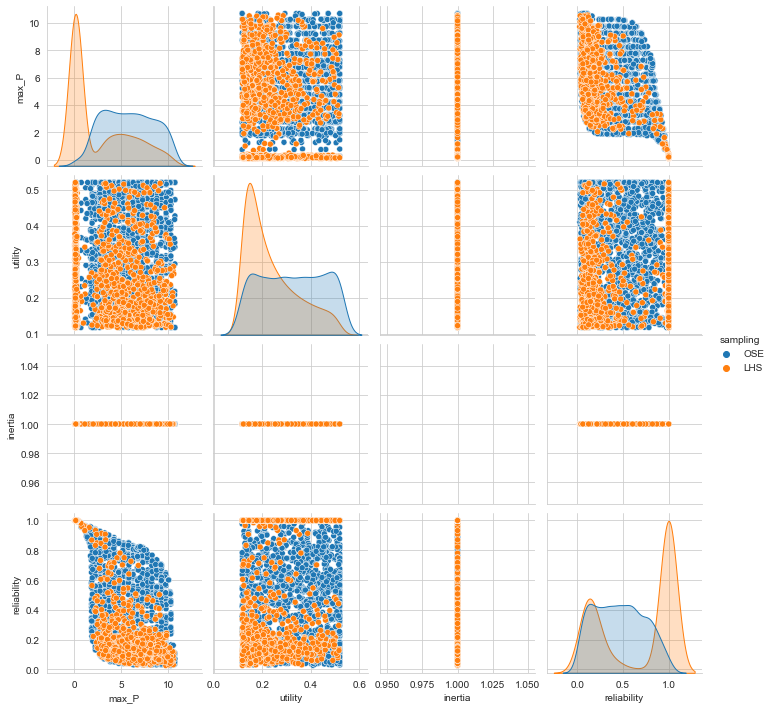

In [12]:
# sns.pairplot(data, hue='sampling')
sns.pairplot(data, hue='sampling', vars=data.columns[0:4])
plt.show()

As you can clearly see, the output space exploration algorithm has uncovered behaviors that were not seen in the 1500 sample LHS.